# Challenge: Portfolio Optimisation

In [1]:
import csv
import numpy as np
import dynex
from autoqubo import Binarization, SamplingCompiler, SearchSpace, Utils
import yfinance as yf #!pip install yfinance
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Real World Example (Markowitz Mean-Variance Model)

https://arxiv.org/pdf/2303.12601.pdf

In [369]:
# settings:
symbols = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META']
start_date = '2018-01-01'
end_date = '2024-01-01' 
budget = 100

In [370]:
data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  5 of 5 completed


In [381]:
print(data)

Ticker            AAPL        AMZN        GOOG        META        MSFT
Date                                                                  
2018-01-02   40.670971   59.450500   53.250000  181.227707   80.080925
2018-01-03   40.663902   60.209999   54.124001  184.474274   80.453598
2018-01-04   40.852764   60.479500   54.320000  184.134628   81.161713
2018-01-05   41.317890   61.457001   55.111500  186.651962   82.167969
2018-01-08   41.164433   62.343498   55.347000  188.080444   82.251816
...                ...         ...         ...         ...         ...
2023-12-22  193.353287  153.419998  142.720001  353.015472  373.888580
2023-12-26  192.803986  153.410004  142.820007  354.453918  373.968445
2023-12-27  192.903839  153.339996  141.440002  357.450714  373.379547
2023-12-28  193.333298  153.380005  141.279999  357.940216  374.587280
2023-12-29  192.284637  151.940002  140.929993  353.584839  375.345886

[1509 rows x 5 columns]


## Calculate mean returns and covariance matrix:

In [371]:
trading_days = 252; # number of trading days per year
returns = data.pct_change().dropna();
mean_daily_returns = returns.mean();
mean_annual_returns = mean_daily_returns * trading_days # annualized
cov_matrix = returns.cov();
n = len(symbols)
cov_matrix_np = np.zeros((n, n))
cov_matrix_np = np.array(cov_matrix)
cov_matrix_np = cov_matrix_np * trading_days # annualized
mean_vector_np = np.zeros(n)
mean_vector_np = np.array(mean_annual_returns)

In [391]:
print('Mean vector:')
print(mean_daily_returns*trading_days)
print()
print('Covariance matrix:')
print(cov_matrix*trading_days)

Mean vector:
Ticker
AAPL    0.309906
AMZN    0.219349
GOOG    0.211479
META    0.204932
MSFT    0.303639
dtype: float64

Covariance matrix:
Ticker      AAPL      AMZN      GOOG      META      MSFT
Ticker                                                  
AAPL    0.100343  0.069905  0.066677  0.077528  0.071554
AMZN    0.069905  0.125078  0.074557  0.091815  0.074206
GOOG    0.066677  0.074557  0.097505  0.088823  0.071861
META    0.077528  0.091815  0.088823  0.182890  0.078538
MSFT    0.071554  0.074206  0.071861  0.078538  0.090745


## Portfolio Optimisation Model:

In [374]:
def variance(x):
    """
    Variance
    """
    return x@cov_matrix_np@x

def mean(x):
    """
    Mean return
    """
    return x@mean_vector_np

def constraint(x):
    """
    Budget constraint
    """
    return (x.sum() - budget)**2

In [375]:
A, B, C = 1, -1, 100

In [376]:
# Mean-variance portfolio optimization model
def f(x):
    return A*variance(x) + B*mean(x) + C*constraint(x)

## Create QUBO formulation

In [377]:
s = SearchSpace()
weights_vector = Binarization.get_uint_vector_type(n, n)
s.add('x', weights_vector, n * n)

qubo, offset = SamplingCompiler.generate_qubo_matrix(fitness_function=f, input_size=s.size, searchspace=s, use_multiprocessing=False)

if SamplingCompiler.test_qubo_matrix(f, qubo, offset, search_space=s):
    print("QUBO generation successful")
else:
    print("QUBO generation failed - the objective function is not quadratic")

QUBO generation successful


In [397]:
print(qubo[:3], 'offset:',offset)

[[-19900.20956279    400.40137333    800.80274666   1601.60549333
    3203.21098665    200.13980919    400.27961838    800.55923676
    1601.11847353   3202.23694706    200.13335453    400.26670907
     800.53341813   1601.06683626   3202.13367252    200.15505622
     400.31011243    800.62022486   1601.24044972   3202.48089945
     200.14310807    400.28621613    800.57243227   1601.14486454
    3202.28972907]
 [     0.         -39600.21843891   1601.60549333   3203.21098665
    6406.42197331    400.27961838    800.55923676   1601.11847353
    3202.23694706   6404.47389411    400.26670907    800.53341813
    1601.06683626   3202.13367252   6404.26734505    400.31011243
     800.62022486   1601.24044972   3202.48089945   6404.96179889
     400.28621613    800.57243227   1601.14486454   3202.28972907
    6404.57945815]
 [     0.              0.         -78399.63413115   6406.42197331
   12812.84394661    800.55923676   1601.11847353   3202.23694706
    6404.47389411  12808.94778822    8

## Compute on Dynex

In [398]:
print("Best solutions (minimize):")
sampleset = dynex.sample_qubo(qubo, offset, mainnet=False, num_reads=10000, annealing_time=1000)
print(sampleset)

Best solutions (minimize):
[ÐYNEX] PRECISION CUT FROM 10.0 TO 1
[DYNEX] PRECISION SET TO 1
[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬─────────────┬───────────┬───────────────────────────┬─────────┬─────────┬────────────────╮
│   DYNEXJOB │   BLOCK FEE │ ELAPSED   │ WORKERS READ              │ CHIPS   │ STEPS   │ GROUND STATE   │
├────────────┼─────────────┼───────────┼───────────────────────────┼─────────┼─────────┼────────────────┤
│         -1 │           0 │           │ *** WAITING FOR READS *** │         │         │                │
╰────────────┴─────────────┴───────────┴───────────────────────────┴─────────┴─────────┴────────────────╯

[DYNEX] FINISHED READ AFTER 0.00 SECONDS
[DYNEX] SAMPLESET READY
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 24     energy num_oc.
0  0  1  1  1  1  1  1  0  1  0  1  1  0  1  1  1  0 ...  1 755.648561       1
['BINARY', 1 rows, 1 samples, 25 variables]


In [400]:
sol = sampleset.record[0][0]
x = s.decode_dict(sol)['x']
e = sampleset.first.energy
print(
    f"x={x}, "
    f"energy={e}, "
    f"obj={f(x)}, "
    f"constraint={constraint(x)} "
    f"obj(baseline)={f(np.repeat(100/n, n))} ({f(x)-f(np.repeat(100/n, n))})"
)

x=[30 11 27  1 31], energy=755.6485607431969, obj=755.6485607438183, constraint=0 obj(baseline)=826.0096115957166 (-70.36105085189831)


## Plot Results

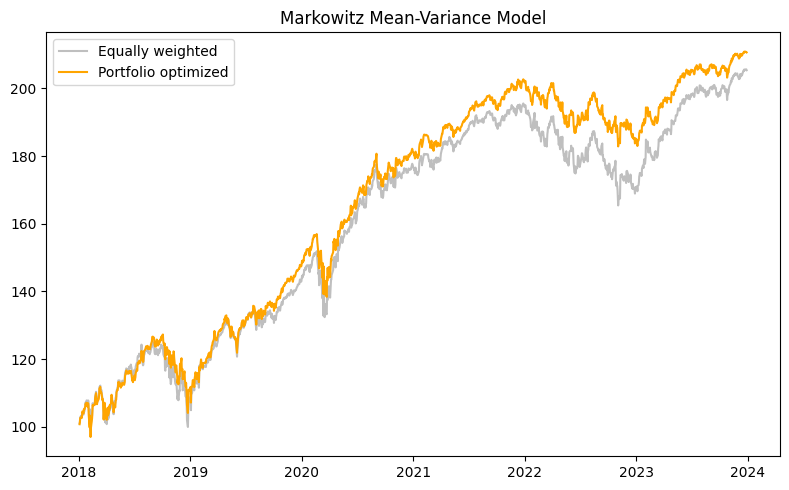

Return (equally weigthed) : 205.3663989425734 %
Return (optimized)        : 210.65131760114411 %
Improved objective by     : -70.36105085189831


In [401]:
portfolio_equally_weighted = [];
portfolio_opt_weighted = [];
pul = budget
pul_opt = budget
returns_np = np.array(returns)

for day in returns_np:
    # equally weighted portfolio:
    budget_day = pul;
    for i in range(0, len(day)):
        asset_weight = (100/n) / budget_day * 100;
        pul += asset_weight * day[i]
    portfolio_equally_weighted.append(pul)
    
    # optimised weighted portfolio:
    budget_day = pul_opt;
    for i in range(0, len(day)):
        asset_weight = x[i] / budget_day * 100;
        pul_opt += asset_weight * day[i]
    portfolio_opt_weighted.append(pul_opt)

plt.figure(figsize=(8, 5))
plt.title('Markowitz Mean-Variance Model')
plt.plot(data.index[1:], portfolio_equally_weighted, '-', color='gray', label='Equally weighted', alpha=0.5);
plt.plot(data.index[1:], portfolio_opt_weighted, '-', color='orange', label='Portfolio optimized');
plt.legend() 
plt.tight_layout()
plt.show()

print('Return (equally weigthed) :',portfolio_equally_weighted[-1]/budget*100,'%')
print('Return (optimized)        :',portfolio_opt_weighted[-1]/budget*100,'%')
print('Improved objective by     :',f(x)-f(np.repeat(100/n, n)))